# Chapter 7. 토픽 모델링으로 주제 찾기

## 1. 토픽 모델링의 이해

1: https://mobile.newsis.com/view.html?ar_id=NISX20190918_0000772783#_enliple
2: https://cyram.tistory.com/309

### 1.1 LDA(Latent Dirichlet Allocation)



### 1.2 모형의 평가와 적절한 토픽 수의 결정


## 2. 사이킷런을 이용한 토픽 모델링

### 2.1 데이터 준비



In [1]:
import nltk
nltk.download('punkt')
nltk.download('webtext')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package webtext to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package webtext is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 
              'comp.sys.ibm.pc.hardware', 'sci.crypt']

#학습 데이터셋을 가져옴
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

print('#Train set size:', len(newsgroups_train.data))
print('#Selected categories:', newsgroups_train.target_names)

#Train set size: 3219
#Selected categories: ['alt.atheism', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'sci.space', 'talk.religion.misc']


In [3]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english', 
                     max_features=2000, min_df=5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data) 

### 2.2 LDA 토픽 모델링 실행


1: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html <br>
2: Griffiths, Thomas L., and Mark Steyvers. "Finding scientific topics." Proceedings of the National academy of Sciences 101.suppl 1 (2004): 5228-5235.

In [4]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
np.set_printoptions(precision=3)

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수
                                max_iter=5, 
                                topic_word_prior=0.1, doc_topic_prior=1.0,
                                learning_method='online', 
                                n_jobs= -1, #사용 processor 수
                                random_state=0)

review_topics = lda.fit_transform(review_cv)
print('#shape of review_topics:', review_topics.shape)
print('#Sample of review_topics:', review_topics[0])

gross_topic_weights = np.mean(review_topics, axis=0)
print('#Sum of topic weights of documents:', gross_topic_weights)

print('#shape of topic word distribution:', lda.components_.shape)

#shape of review_topics: (3219, 10)
#Sample of review_topics: [0.903 0.007 0.028 0.008 0.007 0.008 0.007 0.007 0.007 0.017]
#Sum of topic weights of documents: [0.088 0.082 0.085 0.112 0.116 0.124 0.102 0.072 0.07  0.149]
#shape of topic word distribution: (10, 2000)


In [5]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        #print(", ".join([feature_names[i]+'('+str(topic[i])+')' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()

print_top_words(lda,cv.get_feature_names_out(), 10)

Topic #0: com, morality, article, keith, sgi, think, sandvik, objective, caltech, moral
Topic #1: image, file, graphics, files, ftp, available, software, use, data, pub
Topic #2: space, nasa, access, launch, earth, orbit, shuttle, digex, lunar, satellite
Topic #3: article, com, just, like, don't, i'm, nntp, host, posting, university
Topic #4: key, clipper, chip, encryption, com, government, keys, law, use, escrow
Topic #5: scsi, com, bit, ibm, bus, know, windows, card, just, university
Topic #6: host, nntp, posting, university, gov, distribution, ___, nasa, com, article
Topic #7: drive, com, disk, hard, controller, drives, dos, tape, floppy, problem
Topic #8: key, public, faq, mail, message, pgp, group, des, uni, sci
Topic #9: god, people, don't, jesus, just, believe, does, say, think, know



### 2.3 최적의 토픽 수 선택하기


n_components: 6, perplexity: 1062.480
n_components: 7, perplexity: 1055.103
n_components: 8, perplexity: 1015.387
n_components: 9, perplexity: 1013.480
n_components: 10, perplexity: 1029.741
n_components: 11, perplexity: 1035.568
n_components: 12, perplexity: 1034.684
n_components: 13, perplexity: 1036.223
n_components: 14, perplexity: 1041.608
n_components: 15, perplexity: 1047.096


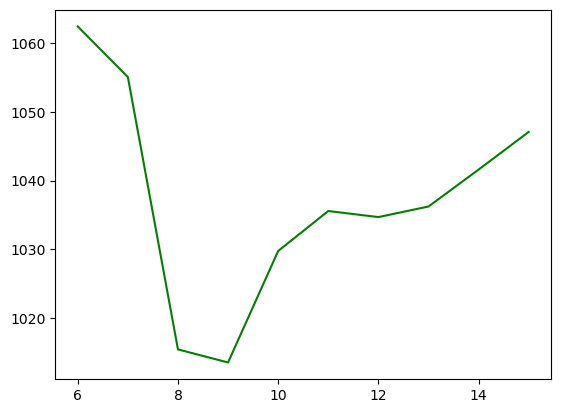

9

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1, 
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components = i, max_iter=max_iter, 
                                        topic_word_prior= topic_word_prior, 
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)    
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

show_perplexity(review_cv, start=6, end=15)

In [7]:
lda = LatentDirichletAllocation(n_components = 8, #추출할 topic의 수를 지정
                                max_iter=20, 
                                topic_word_prior= 0.1, 
                                doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1, 
                                random_state=7)

review_topics = lda.fit_transform(review_cv)

print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: image, graphics, file, available, mail, ftp, data, information, files, software
Topic #1: posting, nntp, host, com, university, gov, article, distribution, nasa, ___
Topic #2: com, keith, morality, article, caltech, think, sgi, objective, don't, posting
Topic #3: com, article, jesus, know, just, don't, god, i'm, good, john
Topic #4: people, god, does, don't, think, say, believe, just, like, way
Topic #5: drive, scsi, card, com, disk, ide, controller, hard, bus, use
Topic #6: space, nasa, access, launch, moon, year, earth, digex, shuttle, henry
Topic #7: key, encryption, clipper, chip, com, government, keys, use, security, public



## 3. Gensim을 이용한 토픽 모델링


### 3.1 Gensim 사용법과 시각화

1: https://radimrehurek.com/gensim/

In [8]:
#!pip install --upgrade gensim

In [9]:
# 필요한 library들을 import
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")

from nltk.tokenize import RegexpTokenizer

RegTok = RegexpTokenizer("[\w']{3,}") # 정규표현식으로 토크나이저를 정의
english_stops = set(stopwords.words('english')) #영어 불용어를 가져옴

def tokenizer(text):
    tokens = RegTok.tokenize(text.lower()) 
    # stopwords 제외
    words = [word for word in tokens if (word not in english_stops) and len(word) > 2]
    return words

texts = [tokenizer(news) for news in newsgroups_train.data]

1: https://radimrehurek.com/gensim/corpora/dictionary.html

In [10]:
from gensim.corpora.dictionary import Dictionary

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n = 2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 46466
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 3219


1: https://radimrehurek.com/gensim/models/ldamodel.html 

In [11]:
from gensim.models import LdaModel

num_topics = 10
passes = 5
%time model = LdaModel(corpus=corpus, id2word=dictionary,\
                       passes=passes, num_topics=num_topics, \
                       random_state=7)

CPU times: total: 3.14 s
Wall time: 5.21 s


In [12]:
model.print_topics(num_words=10)

[(0,
  '0.023*"com" + 0.018*"keith" + 0.016*"caltech" + 0.013*"sgi" + 0.013*"nntp" + 0.013*"posting" + 0.013*"host" + 0.012*"would" + 0.012*"system" + 0.011*"livesey"'),
 (1,
  '0.020*"morality" + 0.018*"objective" + 0.015*"one" + 0.015*"say" + 0.014*"uiuc" + 0.012*"frank" + 0.012*"values" + 0.010*"faq" + 0.010*"article" + 0.008*"cso"'),
 (2,
  '0.026*"com" + 0.025*"access" + 0.025*"posting" + 0.023*"host" + 0.023*"nntp" + 0.017*"digex" + 0.015*"article" + 0.013*"cwru" + 0.013*"___" + 0.013*"net"'),
 (3,
  '0.021*"university" + 0.017*"posting" + 0.015*"host" + 0.015*"nntp" + 0.013*"article" + 0.010*"com" + 0.009*"know" + 0.009*"i\'m" + 0.009*"would" + 0.009*"thanks"'),
 (4,
  '0.032*"com" + 0.015*"would" + 0.011*"article" + 0.010*"one" + 0.010*"get" + 0.009*"people" + 0.009*"ibm" + 0.008*"government" + 0.007*"good" + 0.007*"i\'m"'),
 (5,
  '0.025*"key" + 0.017*"encryption" + 0.014*"clipper" + 0.014*"chip" + 0.009*"keys" + 0.009*"use" + 0.008*"security" + 0.008*"government" + 0.008*"pub

In [13]:
print("#topic distribution of the first document: ", model.get_document_topics(corpus)[0])

#topic distribution of the first document:  [(0, 0.7257734), (8, 0.26994655)]


In [14]:
#!pip install pyldavis

In [15]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

C:\Users\user\anaconda3\envs\text\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.137200  0.040249       1        1  22.655453
5      0.065989  0.123619       2        1  14.522841
9      0.072133  0.092872       3        1  12.987440
7      0.138320  0.043608       4        1  11.020427
4     -0.021828  0.007493       5        1   9.298331
6      0.072783 -0.094709       6        1   9.118877
3      0.027375 -0.054949       7        1   8.494185
0     -0.040788 -0.129975       8        1   4.524033
2      0.005360 -0.091971       9        1   4.051833
1     -0.182145  0.063762      10        1   3.326580, topic_info=            Term         Freq        Total Category  logprob  loglift
538        space  1487.000000  1487.000000  Default  30.0000  30.0000
20           com  3752.000000  3752.000000  Default  29.0000  29.0000
834          key  1316.000000  1316.000000  Default  28.0000  28.0000
1551        scsi   741.000000   741.000000  Default  27.0000  27.0000
70       posting  1723.000000  1723.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
65        people    64.444054  1672.571245  Topic10  -5.1558   0.1469
789          sci    53.263300   309.473890  Topic10  -5.3463   1.6436
602   university    56.862384  1487.218952  Topic10  -5.2810   0.1392
294         time    55.766874  1187.715348  Topic10  -5.3004   0.3446
315       better    54.192171   564.543546  Topic10  -5.3290   1.0597

[592 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1359      1  0.006274      128
1359      2  0.069013      128
1359      3  0.037643      128
1359      4  0.878342      128
153       1  0.057463     1993
...     ...       ...      ...
343       8  0.022394    years
343       9  0.005599    years
343      10  0.121303    years
704       3  0.991487      zoo
705       3  0.984036  zoology

[2804 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 10, 8, 5, 7, 4, 1, 3, 2])

### 3.2 혼란도와 토픽 응집도를 이용한 최적값 선택

https://radimrehurek.com/gensim/models/coherencemodel.html

In [16]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

-1.7493528544065975


num_topics: 6, perplexity: -7.035, coherence: -1.701
num_topics: 7, perplexity: -7.023, coherence: -1.735
num_topics: 8, perplexity: -7.023, coherence: -1.547
num_topics: 9, perplexity: -7.007, coherence: -1.891
num_topics: 10, perplexity: -6.996, coherence: -1.888
num_topics: 11, perplexity: -7.027, coherence: -2.164
num_topics: 12, perplexity: -7.019, coherence: -2.018
num_topics: 13, perplexity: -7.025, coherence: -2.255
num_topics: 14, perplexity: -7.020, coherence: -2.082
num_topics: 15, perplexity: -7.019, coherence: -2.521


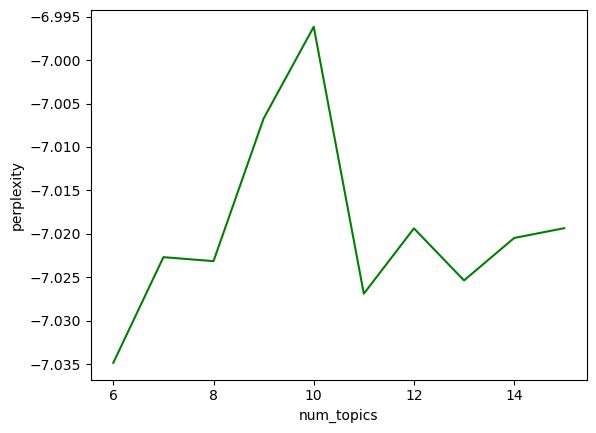

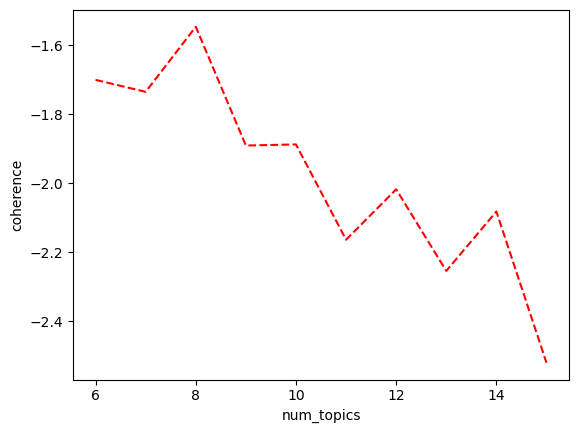

In [17]:
def show_coherence(corpus, dictionary, start=6, end=15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                 chunksize=1000, num_topics=i,
                 random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)
        
        cm = CoherenceModel(model=model, corpus=corpus, 
                            coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

show_coherence(corpus, dictionary, start=6, end=15)

## 4. 토픽트렌드로 시간에 따른 주제의 변화 알아내기

1: https://github.com/akngs/petitions

In [18]:
import pandas as pd

df = pd.read_csv("./data/petition_sampled.csv") #read data
df.head(1)

,article_id,start,end,answered,votes,category,title,content
0,58,2017-08-19,2017-11-17,0,21,일자리,국토교통부와 한국주택협회가 행한 부당한 행위와 권력남용에 대한 내용을 청원드립니다.,안녕하세요? 존경하고 지지하는 문재인 대통령님!\n저는 성남시 분당구 정자동 주택전...


In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt #konlpy에서 Twitter 형태소 분석기를 import
twit = Okt()

def tokenizer(doc):
    return [token for token in twit.nouns(doc) if len(token) > 1]

vec = CountVectorizer(tokenizer=tokenizer, #우선은 명사만 사용
                      max_df=0.5, min_df = 5, 
                      max_features = 1000) #적당한 대상 단어 수를 선택

pet_cv = vec.fit_transform(df.content)
print(pet_cv.shape)

(18077, 1000)


In [20]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 15, \
                                n_jobs= -1, \
                                random_state=0)

%time pet_topics = lda.fit_transform(pet_cv)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] 
                         for i in topic.argsort()[:-n_top_words - 1:-1]]))
print_top_words(lda,vec.get_feature_names(), 10)

CPU times: total: 125 ms
Wall time: 2.66 s
Topic #0: 사람, 생각, 대통령, 국민, 나라, 정말, 지금, 병원, 대한민국, 사건
Topic #1: 북한, 한국, 우리, 대통령, 국민, 정부, 대한민국, 미국, 일본, 문재인
Topic #2: 아이, 부모, 생각, 어린이집, 엄마, 교사, 우리, 유치원, 가정, 자녀
Topic #3: 청소년, 불법, 폐지, 보호, 장애인, 조직, 생각, 사찰, 게임, 이용
Topic #4: 정부, 정책, 주택, 부동산, 서민, 아파트, 국민, 세금, 나라, 투기
Topic #5: 일자리, 기업, 회사, 생각, 근무, 정부, 근로자, 시간, 임금, 최저임금
Topic #6: 국민, 청원, 국회의원, 국회, 난민, 의원, 건강, 의료, 반대, 세금
Topic #7: 내용, 조사, 대한, 관리, 관련, 판결, 사실, 확인, 업무, 처리
Topic #8: 학생, 학교, 교육, 선수, 시험, 생각, 대학, 공부, 교사, 선생님
Topic #9: 연금, 보험, 국민연금, 공무원, 방송, 지급, 국민, 소득, 가입, 국가
Topic #10: 여성, 사회, 공무원, 대한민국, 생각, 남성, 국민, 의무, 남자, 나라
Topic #11: 경찰, 범죄, 국민, 사건, 위해, 조직, 대한민국, 불법, 만행, 경찰서
Topic #12: 처벌, 피해자, 사건, 차량, 사고, 피해, 가해자, 범죄, 경우, 대한
Topic #13: 민원, 화폐, 가상, 정부, 투자, 거래, 시장, 계획, 규제, 주민
Topic #14: 지역, 사람, 대출, 저희, 서울, 미세먼지, 생각, 문제, 은행, 사용


C:\Users\user\anaconda3\envs\text\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [21]:
trend_data = pd.DataFrame(pet_topics, columns=['Topic'+str(i) for i in range(1, 16)])
trend_data = pd.concat([trend_data, df.start.map(lambda x: x[:7])], axis=1)
trend_data.iloc[:5, -5:]

,Topic12,Topic13,Topic14,Topic15,start
0,0.000307,0.000307,0.000307,0.000307,2017-08
1,0.000813,0.000813,0.000813,0.393834,2017-08
2,0.001449,0.001449,0.001449,0.001449,2017-08
3,0.000227,0.000227,0.000227,0.000227,2017-08
4,0.000447,0.046377,0.000447,0.000447,2017-08


In [22]:
trend = trend_data.groupby(['start']).mean()
trend.iloc[:5, -5:]

,Topic11,Topic12,Topic13,Topic14,Topic15
start,,,,,
2017-08,0.046763,0.018676,0.025943,0.026137,0.086531
2017-09,0.046787,0.022686,0.123019,0.020895,0.038985
2017-10,0.088040,0.054059,0.069562,0.029880,0.082948
2017-11,0.048525,0.041486,0.230528,0.039703,0.041132
2017-12,0.060431,0.031496,0.073957,0.053224,0.066043


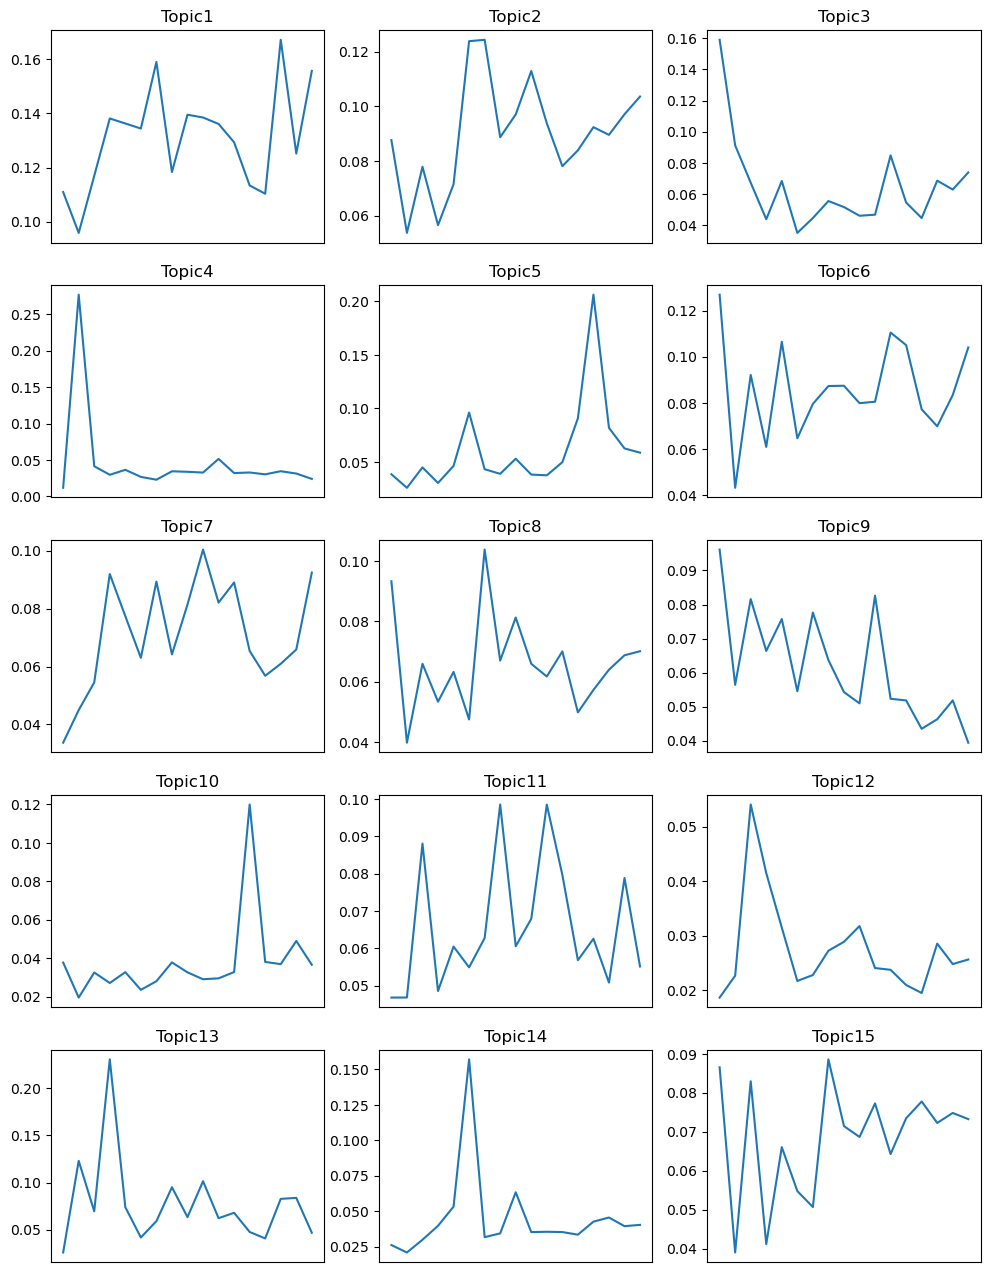

In [23]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(5, 3, sharex='col', figsize=(12, 16)) 
for col, ax in zip(trend.columns.tolist(), axes.ravel()): 
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend[col])
plt.show()

## 5. 동적 토픽 모델링(Dynamic Topic Modeling)

In [24]:
import pandas as pd

df = pd.read_csv("./data/petition_sampled.csv") 
df_sorted = df.sort_values(by='start') # 문서를 시작날짜 순으로 정렬

# time slice를 생성. 월별로 변화를 보기 위해 연도와 월만 추출하여 time 열 생성
df_sorted['time'] = df_sorted['start'].map(lambda x: x[:7])

# 각 월별로 문서가 몇건인지를 계산하여 time_slice에 저장
time_slice = list(df_sorted['time'].value_counts().sort_index())
print(time_slice, sum(time_slice))

[83, 906, 298, 1446, 926, 1514, 1304, 1097, 1217, 1301, 1246, 1291, 1390, 1155, 1277, 1187, 439] 18077


In [25]:
# 시간 구간을 리스트로 작성
time_tag = sorted(list(set(df_sorted['time'])))
print(time_tag)

['2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12']


In [26]:
from gensim.corpora.dictionary import Dictionary
from konlpy.tag import Okt #konlpy에서 Twitter 형태소 분석기를 import
twit = Okt()

def tokenizer(doc): #명사만 사용
    return [token for token in twit.nouns(doc) if len(token) > 1]

#청원데이터의 텍스트를 토큰화
texts = [tokenizer(news) for news in df_sorted['content']]

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts) 
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n = 2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 36344
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 18077


num_topics: 6, perplexity: -6.903, coherence: -2.204
num_topics: 7, perplexity: -6.885, coherence: -2.174
num_topics: 8, perplexity: -6.886, coherence: -2.181
num_topics: 9, perplexity: -6.875, coherence: -2.323
num_topics: 10, perplexity: -6.860, coherence: -2.298
num_topics: 11, perplexity: -6.863, coherence: -2.355
num_topics: 12, perplexity: -6.864, coherence: -2.616
num_topics: 13, perplexity: -6.872, coherence: -2.333
num_topics: 14, perplexity: -6.884, coherence: -2.439
num_topics: 15, perplexity: -6.946, coherence: -2.452


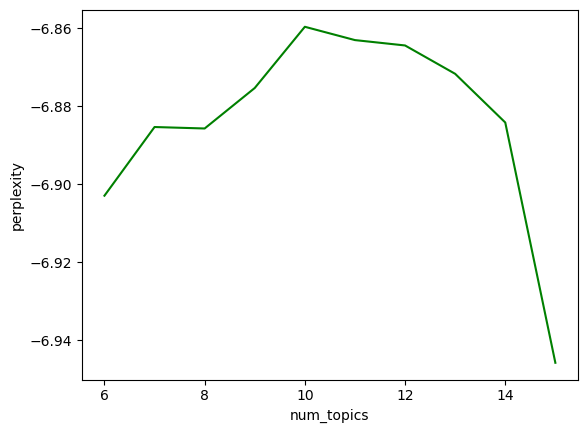

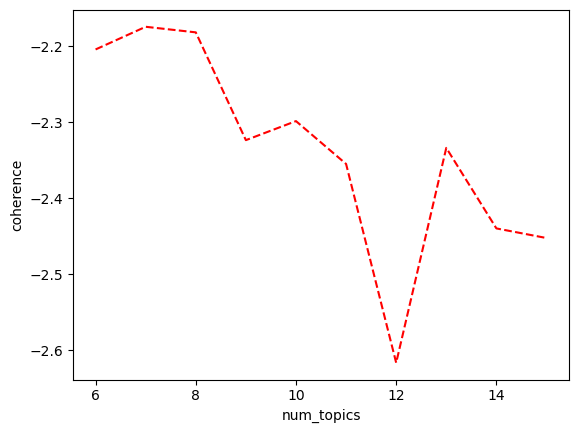

In [27]:
# 적절한 토픽의 수를 알아보기 위해 토픽수를 바꿔가면서 log_perplexity와 coherence를 계산
from gensim.models import CoherenceModel

coherence = cm.get_coherence()
show_coherence(corpus, dictionary, start=6, end=15)

In [28]:
# LdaSeqModel를 실행
from gensim.models import LdaSeqModel
import warnings
warnings.filterwarnings("ignore")

#시간이 많이 소요됨
ldaseq = LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=time_slice, num_topics=6, random_state=7)

In [29]:
# 토픽결과로부터 상위 n개의 단어만 반환하는 함수 작성
def get_topic_words(topic, top_n_words=10):
    words, _ = zip(*topic)
    return words[:top_n_words]

# 주어진 토픽에 대해 시간별로 상위단어를 간략하게 출력하는 함수 작성
def print_topic_times(model, topic, time_tag, top_n_words=10):
    topic_times = model.print_topic_times(topic)
    for i in range(len(topic_times)):
        print(time_tag[i]+':', get_topic_words(topic_times[i], top_n_words))

In [30]:
# 4번 토픽에 대해 시간 별로 상위 8개의 단어를 출력
print_topic_times(ldaseq, 4, time_tag, 8)

2017-08: ('청소년', '보호', '경찰', '생각', '범죄', '폐지', '사건', '피해자')
2017-09: ('청소년', '보호', '생각', '경찰', '범죄', '폐지', '사건', '피해자')
2017-10: ('경찰', '범죄', '국민', '대한민국', '사람', '위해', '피해자', '청소년')
2017-11: ('경찰', '범죄', '국민', '사람', '대한민국', '위해', '사건', '생각')
2017-12: ('사람', '경찰', '범죄', '생각', '처벌', '대한민국', '국민', '피해자')
2018-01: ('사람', '선수', '처벌', '생각', '피해자', '여성', '범죄', '경찰')
2018-02: ('사람', '선수', '처벌', '생각', '여성', '피해자', '사회', '범죄')
2018-03: ('사람', '처벌', '여성', '생각', '피해자', '사회', '선수', '범죄')
2018-04: ('사람', '처벌', '생각', '여성', '피해자', '사회', '범죄', '사건')
2018-05: ('사람', '처벌', '생각', '여성', '피해자', '사건', '범죄', '사회')
2018-06: ('사람', '처벌', '생각', '여성', '피해자', '사회', '사건', '범죄')
2018-07: ('사람', '처벌', '생각', '여성', '피해자', '사건', '사회', '남성')
2018-08: ('사람', '생각', '처벌', '여성', '피해자', '사건', '남성', '사회')
2018-09: ('사람', '생각', '처벌', '여성', '사건', '피해자', '사회', '남성')
2018-10: ('사람', '처벌', '생각', '사건', '피해자', '여성', '사회', '범죄')
2018-11: ('사람', '처벌', '생각', '사건', '피해자', '여성', '사회', '범죄')
2018-12: ('사람', '처벌', '생각', '사건', '여성', '피해자', '

In [31]:
# 구간별로 문서 토픽 분포의 평균을 구하여 토픽의 트렌드로 사용
def get_topic_trends(model, corpus, time_slice):
    dtm = model.dtm_vis(0, corpus) #dtm_vis 메서드를 이용해 문서별 토픽분포를 가져옴
    result = []
    start = 0
    for index in time_slice: # 각 구간별 문서들에 대해 토픽분포의 평균을 구함
        result.append(np.array(dtm[0][start:start+index]).mean(axis=0))
        start += index
    return np.array(result)
topic_trends = get_topic_trends(ldaseq, corpus, time_slice)

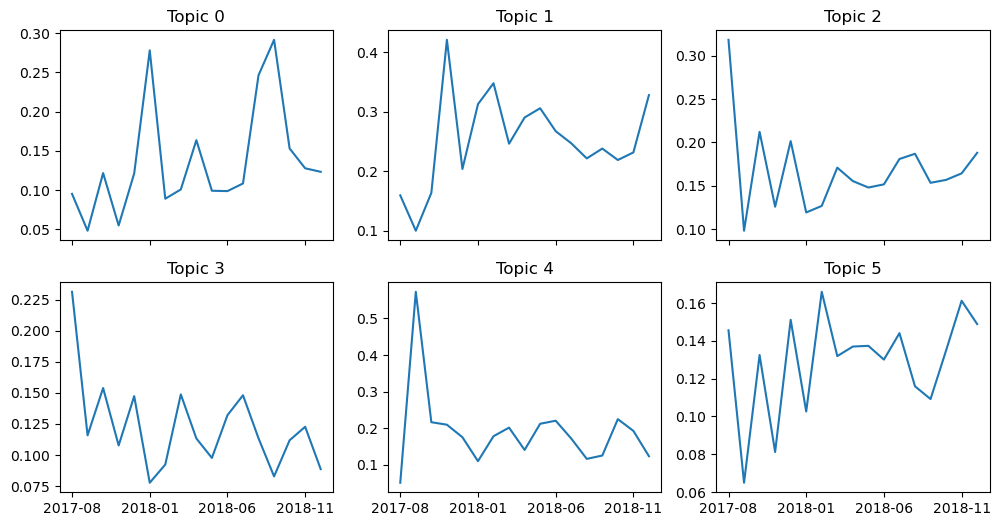

In [32]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

topic_titles = ['Topic '+str(i) for i in range(6)] # 토픽 타이틀 생성
fig, axes = plt.subplots(2, 3, sharex='col', figsize=(12, 6)) 
for i, (title, ax) in enumerate(zip(topic_titles, axes.ravel())): 
    ax.set_title(title)
    ax.set_xticks([0, 5, 10, 15])
    ax.set_xticklabels(time_tag[::5])
    ax.plot(topic_trends[:, i])
plt.savefig('dtm.png')
plt.show()

In [34]:
import pyLDAvis
pyLDAvis.enable_notebook()

# 특정 time slice의 토픽분포를 시각화 - ldaseq.dtm_vis() 메서드를 이용
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=0, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm) #결과를 출력
#pyLDAvis.save_html(vis_dtm, 'lda_time0.html')) #결과를 별도의 html 파일로 저장

In [35]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=1, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)
#pyLDAvis.save_html(vis_dtm, 'lda_time1.html')